In [3]:
# Load the regular expression library
import re
import sys
!{sys.executable} -m pip install inline
!{sys.executable} -m pip install matplotlib
import inline
import matplotlib
import pandas as pd

data = pd.read_csv('march_27_tweet.csv', low_memory=False)

# Filter to only English entries.
data = data[data['lang'] == 'en']

#remove columns other than the tweet, place, or user_location
data.drop(data.columns.difference(['text', 'place', 'user_location']), 1, inplace=True)

#filter out rows that
data1 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('california', flags=re.IGNORECASE, regex=True)).all(axis=1)]
data2 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('CA')).all(axis=1)]
data = [data1, data2]
result = pd.concat(data)
result.head()
#print(result)

  Using cached matplotlib-3.3.2-cp38-cp38-macosx_10_9_x86_64.whl (8.5 MB)
  Using cached kiwisolver-1.2.0-cp38-cp38-macosx_10_9_x86_64.whl (60 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 2.2 MB 394 kB/s eta 0:00:01


,place,text,user_location
221,NaN,California officials implore people not to flu...,NaN
1714,NaN,Coronavirus Southern California update: Los An...,NaN
2935,NaN,@NoLabelsFitMe @mmfa Just more insanity in blu...,Southern California
10530,NaN,⚡️ “California DMV closing all field offices t...,NaN
11770,NaN,"California is the next New York, and New York ...",NaN


In [14]:
import os
os.chdir('..')

# Remove punctuation
result['tweet_text_processed'] = result['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
result['tweet_text_processed'] = result['tweet_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
result['tweet_text_processed'].head()


tweet_text_processed


In [5]:
!{sys.executable} -m pip install wordcloud

  Using cached wordcloud-1.8.0-cp38-cp38-macosx_10_6_x86_64.whl (162 kB)


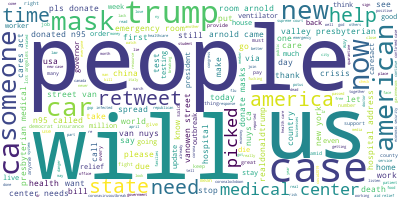

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(result['tweet_text_processed'].values))

#add stopwords from twitter and take out covid stuff we know the tweets are about covid
stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "california", "pandemic"] + list(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

/Users/marcosgonzalez/Desktop/anaconda3/envs/new-r/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


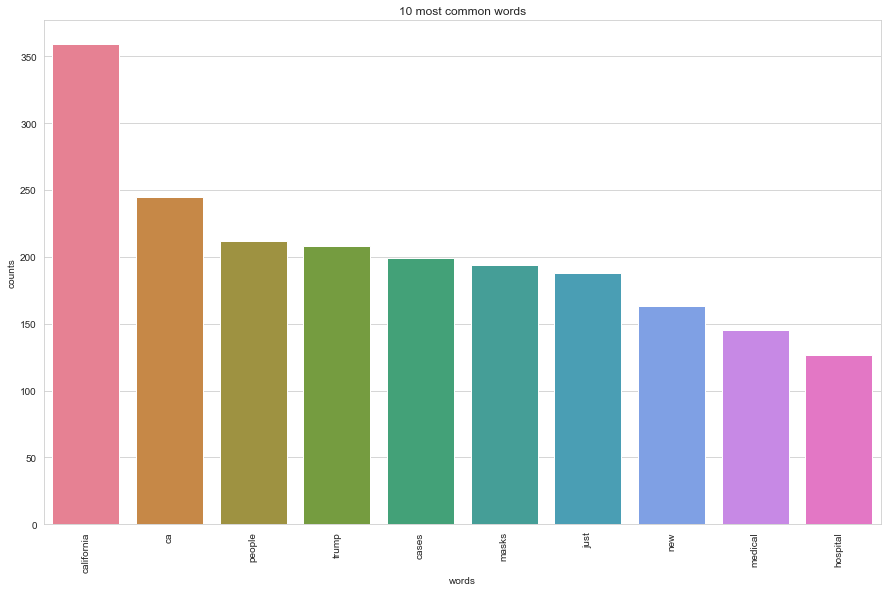

In [15]:
# Load the library with the CountVectorizer method
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import numpy as np

#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words and same ones from wordcloud
my_additional_stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "covidー19"]
count_vectorizer = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(result["tweet_text_processed"])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [16]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
california people pandemic ca evictions offices health amid today newsom

Topic #1:
california cases trump new help america deaths china people like

Topic #2:
california people ca care insurance die new sir health american

Topic #3:
masks ca just act medical needs emergency hospital cares pls

Topic #4:
trump pandemic ca people america americans join sign daca job


In [18]:
%%time

!{sys.executable} -m pip install pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

     |████████████████████████████████| 1.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 3.5 MB/s ta 0:00:01
  Using cached pytest-6.1.1-py3-none-any.whl (272 kB)
     |████████████████████████████████| 829 kB 5.5 MB/s eta 0:00:01
  Using cached pluggy-0.13.1-py2.py3-none-any.whl (18 kB)
  Using cached toml-0.10.1-py2.py3-none-any.whl (19 kB)
  Using cached py-1.9.0-py2.py3-none-any.whl (99 kB)
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=5bd9b6030515725ff5f325954c7363a39ff223d7d0099a2d95e4dd1b997f2b1e
  Stored in directory: /Users/marcosgonzalez/Library/Caches/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=d8b48110c9e238629bed96915cb8de70c39fb4afecf7d6756342e8b274ef5a77
  Stored in directory: /Users/marcosgonzalez/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Succ

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.192337  0.001390       1        1  30.529299
2     -0.043628 -0.119929       2        1  20.115701
0     -0.054764 -0.010778       3        1  17.642420
4     -0.047825  0.073789       4        1  16.452057
1     -0.046120  0.055527       5        1  15.260523, topic_info=              Term        Freq       Total Category  logprob  loglift
6466         masks  158.000000  158.000000  Default  30.0000  30.0000
808            act   87.000000   87.000000  Default  29.0000  29.0000
7749           pls   82.000000   82.000000  Default  28.0000  28.0000
837        address   79.000000   79.000000  Default  27.0000  27.0000
2207        center   79.000000   79.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
4409   gavinnewsom    8.440207   28.453457   Topic5  -6.4411   0.6646
7489      pandemic   10.520988   89.861338   Topic5  -6.2207  -0.2650
10951        world    9.540784   65.894019   Topic5  -6.3185  -0.0526
2118          case    8.272949   33.798345   Topic5  -6.4611   0.4725
5720          just    8.509048  148.012874   Topic5  -6.4330  -0.9763

[327 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
121        1  0.998157                    15107
129        2  0.771449                       17
129        3  0.140263                       17
183        1  0.224189                     2020
183        2  0.149459                     2020
...      ...       ...                      ...
10995      4  0.788232                      wtp
10999      2  0.885263          wuhanchinavirus
11001      2  0.885263  wuhanhealthorganisation
11159      3  0.072770                    youth
11159      4  0.873244                    youth

[592 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])